## PKIS2 kinase-informed notebook
In this notebook, we create the workflow for the following model setting:

- Data set: PKIS2 which uses KinomeScan assays
- Molecular component type: ligand-based
- Ligand feature: Morgan fingerprint
- Kinase feature: scaled binding site composition
- Model Architecture: tree-based (using XGBoost) and then a dense neural network


We will consider the following metrics:
- Loss: MSE
- Goodness of fit: $R^2$

We will test different evaluation strategies: train-test split 
- [ ] Random (K fold)

In [1]:
%load_ext autoreload

%autoreload 2

import warnings
warnings.simplefilter("ignore")
import logging
logging.basicConfig(level=logging.ERROR)
import numpy as np

### Load PKIS2 data

In [2]:
from kinoml.datasets.kinomescan.pkis2 import PKIS2DatasetProvider

### First as a DatasetProvider

In [3]:
pkis2 = PKIS2DatasetProvider.from_source()

### Now as a pandas dataframe

In [4]:
df = pkis2.to_dataframe()
df

,Systems,n_components,PercentageDisplacementMeasurement
0,AAK1 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2...,2,14.0
1,ABL1-nonphosphorylated & Clc1cccc(Cn2c(nn3c2nc...,2,28.0
2,ABL1-nonphosphorylated & Clc1cccc(Cn2c(nn3c2nc...,2,20.0
3,ABL2 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2...,2,5.0
4,ACVR1 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C...,2,0.0
...,...,...,...
261865,ZAP70 & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)cc12)...,2,0.0
261866,p38-alpha & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)c...,2,0.0
261867,p38-beta & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)cc...,2,0.0
261868,p38-delta & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)c...,2,0.0


### A few statistics about this data

In [5]:
import matplotlib.pyplot as plt

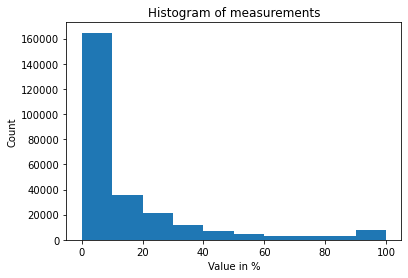

In [6]:
f = plt.figure
plt.hist(df['PercentageDisplacementMeasurement'])
plt.xlabel('Value in %')
plt.ylabel('Count')
plt.title('Histogram of measurements')
plt.show()

In [7]:
print("Measurements:", len(pkis2.measurements))
print("Systems:", len(pkis2.systems))
print("Ligands:", len(set([s.ligand for s in pkis2.systems])))
print("Proteins:", len(set([s.protein for s in pkis2.systems])))

Measurements: 261870
Systems: 257920
Ligands: 640
Proteins: 403


In [8]:
from collections import Counter
print('Number of zeros : ',
      Counter(df['PercentageDisplacementMeasurement'] == 0.0))

Number of zeros :  Counter({False: 139025, True: 122845})


### Featurize the ligand
We use the Morgan fingerprint and set the radius at 2, the vector length at 1024.

In [9]:
from kinoml.features.ligand import MorganFingerprintFeaturizer

In [10]:
morgan_featurizer = MorganFingerprintFeaturizer(nbits=1024, radius=2)

### Featurize the kinase

In [11]:
from kinoml.features.protein import AminoAcidCompositionFeaturizer
from kinoml.features.core import ScaleFeaturizer, Concatenated, Pipeline

In [12]:
composition_featurizer = Pipeline([AminoAcidCompositionFeaturizer(),
                                   ScaleFeaturizer()])

### Model input featurizers
For this model, we concatenate the ligand and kinase featurizers as to have one single vector as input for the considered model.

We then featurize all the systems in PKIS2. 

In [13]:
concat_featurizers = Concatenated([morgan_featurizer,
                                   composition_featurizer], axis=0)

In [14]:
pkis2.featurize(concat_featurizers)

[<ProteinLigandComplex with 2 components (<AminoAcidSequence name=CDK3>, <Ligand name=N#CC1=CC(N2)=C(C=C1)C3=C2C4=CC(OC)=C(OCCOCCOC)C=C4N=C3>)>,
 <ProteinLigandComplex with 2 components (<AminoAcidSequence name=CDK3>, <Ligand name=Cl.COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC>)>,
 <ProteinLigandComplex with 2 components (<AminoAcidSequence name=HIPK1>, <Ligand name=OC(=O)C(F)(F)F.CC(C)(CN)c1nc(c([nH]1)-c1ccncc1)-c1ccc(Cl)c(O)c1>)>,
 <ProteinLigandComplex with 2 components (<AminoAcidSequence name=HUNK>, <Ligand name=Clc1ccc(cc1)C1=C(Nc2cccc(Cl)c2)C(=O)NC1=O>)>,
 <ProteinLigandComplex with 2 components (<AminoAcidSequence name=CDK4>, <Ligand name=N#CC1=CC(N2)=C(C=C1)C3=C2C4=CC(OC)=C(OCCOCCOC)C=C4N=C3>)>,
 <ProteinLigandComplex with 2 components (<AminoAcidSequence name=CDK4>, <Ligand name=Cl.COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC>)>,
 <ProteinLigandComplex with 2 components (<AminoAcidSequence name=HIPK2>, <Ligand name=OC(=O)C(F)(F)F.CC(C)(CN)c1nc(c([nH]1)-c1ccncc1)-c1ccc(Cl)c(O)c1>)>,
 <ProteinLigan

### XGBoost package
We export the data to be compatible with the XGBoost libraray.

In [15]:
data = pkis2.to_xgboost()
data

### Objective function
The objective function is the function which is optimized in the algorithm. It is a custom loss function which depends on the observation model.

In [16]:
obj_function = pkis2.loss_adapter(backend="xgboost", loss="mse")
obj_function

<function kinoml.core.measurements.PercentageDisplacementMeasurement._loss_adapter_xgboost__mse(dG_over_KT, dmatrix, inhibitor_conc=1, standard_conc=1, **kwargs)>

### Model Training

We define the tree-based model _per say_ and train it.

In [17]:
import xgboost as xgb
params = {'learning_rate': 1.0}
model = xgb.train(dtrain=data, params=params, obj=obj_function)

### Model evaluating
We evaluate the model on the data set, which gives us a prediction for $\Delta g$. Given the prediction, we then apply the observation model to obtain the predictions for the observed values. 


In [18]:
observation_model = pkis2.observation_model(backend="xgboost")
observation_model

<function kinoml.core.measurements.PercentageDisplacementMeasurement._observation_model_numpy(dG_over_KT, inhibitor_conc=1, standard_conc=1, **kwargs)>

In [19]:
deltag_train = model.predict(data) # model predicts deltag

In [20]:
prediction = observation_model(deltag_train) # Apply observation model to predicted deltag

In [21]:
true = data.get_label() # true, observed values

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

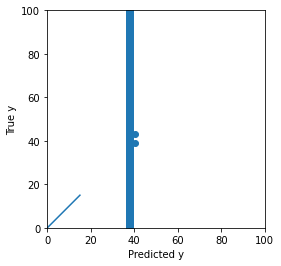

R2: Goodness of fit measure: -1.09
MSE: 1084.54
RMSE: 32.93
MAE: 30.78


In [23]:
fig, ax = plt.subplots()
ax.scatter(prediction, true)
ax.set(xlim=(0, 100), ylim=(0, 100))
ax.set_xlabel("Predicted y")
ax.set_ylabel("True y")
x = np.linspace(0, 15, 10)
ax.plot(x, x)
ax.set_aspect('equal', adjustable='box')
plt.show()

r2 = r2_score(true, prediction)
print(f"R2: Goodness of fit measure: {r2:.2f}")
if all(elem==prediction[0] for elem in prediction):
    print("All outputs are equal: ")
mse = mean_squared_error(true, prediction)
mae = mean_absolute_error(true, prediction)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

### Neural Network
Let's see how the model performs if we use a neural network instead.

Let's export the data to pytorch.

In [30]:
datasets = pkis2.to_pytorch()
datasets

We define the observation model which maps $\Delta g$ to percentage displacement measurement types.

In [41]:
pct_displacement_model = pkis2.measurement_type.observation_model(backend="pytorch")

In [44]:
import torch
from kinoml.ml.torch_models import NeuralNetworkRegression

# Use DataLoader for minibatches
loader = datasets.as_dataloader(batch_size=512)

model = NeuralNetworkRegression(input_size=datasets.systems[0].shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss() # Mean squared error

print(f"{model} has {sum(param.numel() for param in model.parameters())} parameters")

nb_epoch = 100
loss_timeseries = []
for epoch in range(nb_epoch):
    
    cumulative_loss = 0
    for i, (x, y) in enumerate(loader, 1):
        # Clear gradients
        
        optimizer.zero_grad()
        
        # Obtain model prediction given model input
        # x.requires_grad_()
        delta_g = model(x)

        # with observation model
        # with torch.no_grad():
        prediction = pct_displacement_model(delta_g)
        loss = loss_function(prediction, y)

        # Obtain loss for the predicted output
        cumulative_loss += loss.item()

        # Gradients w.r.t to parameters
        loss.backward()

        # Optimizer
        optimizer.step()
    loss_timeseries.append(cumulative_loss)
    if epoch % 10 == 0:
        print(f"epoch {epoch} : loss {loss_timeseries[-1]}")
print("Done!")

NeuralNetworkRegression(
  (fully_connected_1): Linear(in_features=1044, out_features=100, bias=True)
  (fully_connected_out): Linear(in_features=100, out_features=1, bias=True)
) has 104601 parameters
epoch 0 : loss 274594.88081359863
epoch 10 : loss 249285.680809021
epoch 20 : loss 247359.7423248291
epoch 30 : loss 246412.72972869873
epoch 40 : loss 245900.07284545898
epoch 50 : loss 245723.9507675171
epoch 60 : loss 245488.7672805786
epoch 70 : loss 245371.26950073242
epoch 80 : loss 245303.5404663086
epoch 90 : loss 245209.3161239624
Done!


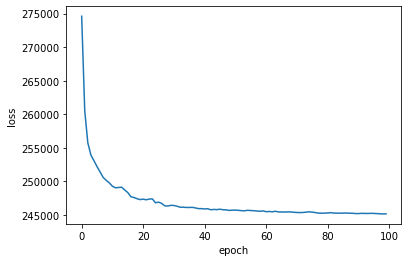

In [47]:
f = plt.figure()
plt.plot(loss_timeseries)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [52]:
model_input = torch.tensor(datasets.systems).type(torch.FloatTensor)
true = datasets.measurements

delta_g = model(model_input)
prediction = datasets.observation_model(delta_g).detach().numpy()

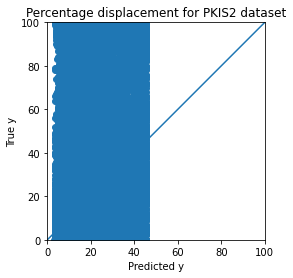

R2: Goodness of fit measure: 0.11
MSE: 460.75
RMSE: 21.47
MAE: 15.26


In [54]:
fig, ax = plt.subplots()
ax.scatter(prediction, true)
ax.set(xlim=(0, 100), ylim=(0, 100))
ax.set_xlabel("Predicted y")
ax.set_ylabel("True y")
ax.set_title(f"Percentage displacement for PKIS2 dataset")
x = np.linspace(0, 100, 10)
ax.plot(x, x)
ax.set_aspect('equal', adjustable='box')
plt.show()

r2 = r2_score(true, prediction)
print(f"R2: Goodness of fit measure: {r2:.2f}")
if all(elem==prediction[0] for elem in prediction):
    print("All outputs are equal: ")
mse = mean_squared_error(true, prediction)
mae = mean_absolute_error(true, prediction)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")